# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [19]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [20]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [21]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [22]:
def train_test_model(epoch : int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     device: torch.device = 'cpu'):
    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []
    for epochs in range(epoch):
        epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
        train_loss_arr.append(epoch_loss / len(train_loader))

        scheduler.step(epoch_loss)
        after_lr = optimizer.param_groups[0]['lr']

        test_loss = test_step(model, test_loader, loss_fn, device)
        test_loss_arr.append(test_loss / len(test_loader))

        if (epochs) % 10 == 0 or epochs == 0:
            print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
        elif epochs + 1 == epoch:
            print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
    
    return train_loss_arr, test_loss_arr

Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [23]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               scaler,
               device: torch.device = 'cpu'):

    model.eval()
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds)
    y_true_real = scaler.inverse_transform(all_targets)

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std" : std_distance_error.item()
    }


Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [24]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Η συνάρτηση αυτή δέχεται τα paths των δεδομένων, δημιουργεί και επιστρέφει τα mini_batches που θα χρησιμοποιηθούν στο training.

Κάνουμε scale και το Y οπότε σε περίπτωση τυχαίου διανύσματος θα πρέπει να το κάνουμε και αυτό scale, και μετά το output να το επαναφέρουμε.

In [25]:
def data_func(input_array, labels, batch_size = 32, test_size = 0.2):
    # Reshape the tensor to 2D so that it can be used in the linear model
    X = input_array.reshape(len(input_array), -1)
    y = labels[:,:2]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler_X = StandardScaler()
    # Fit the scaler_X on the training data and transform both the training and test sets
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    # Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
    y_train = scaler_Y.fit_transform(y_train)
    y_test = scaler_Y.transform(y_test)

    # Transform the data to PyTorch tensors and move them to the GPU if available
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the dataset
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Define the data loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [26]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

parent_dir = os.path.join(parent_dir, '..', 'Experiments', 'Raw_Data_0') 


rfid_label = np.load(f"{parent_dir}\\final_labels.npy")
info_tensor = np.load(f"{parent_dir}\\final_tensor.npy")

rfid_label = rfid_label[:,:2]

info_tensor.shape , rfid_label.shape

((1013, 500, 4), (1013, 2))

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως **κινήθηκε** και την μέτρηση της **φάσης** του.

In [27]:
train_loader, test_loader, scaler_rev= data_func(info_tensor, rfid_label)

In [28]:
len(train_loader) # Should be (total_tags / batch_size) * train_partition rounded to the upper integer

26

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [29]:
output_len = rfid_label.shape[1]
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(2000, 2)

***

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [30]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 15.60181469642199 | Loss test: 4.4165083680834085 | lr = 0.01
Epoch 10 | Loss train: 1.642031653569295 | Loss test: 2.4400447266442433 | lr = 0.01
Epoch 20 | Loss train: 0.5752251423322238 | Loss test: 0.7206352693693978 | lr = 0.001
Epoch 30 | Loss train: 0.5598772638119184 | Loss test: 0.7778070569038391 | lr = 0.001
Epoch 40 | Loss train: 0.4680951564357831 | Loss test: 0.6350076624325344 | lr = 0.0001
Epoch 50 | Loss train: 0.47163801754896456 | Loss test: 0.6353739500045776 | lr = 1e-05
Epoch 60 | Loss train: 0.4639538927720143 | Loss test: 0.6310238497597831 | lr = 1e-05
Epoch 70 | Loss train: 0.46092813175458175 | Loss test: 0.6304090278489249 | lr = 1e-05
Epoch 80 | Loss train: 0.46258991727462184 | Loss test: 0.6295965995107379 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.47195184803926027 | Loss test: 0.629511432988303 | lr = 1.0000000000000002e-07
Epoch 100 | Loss train: 0.46080423433047074 | Loss test: 0.6295116118022374 | lr = 1.000000000000

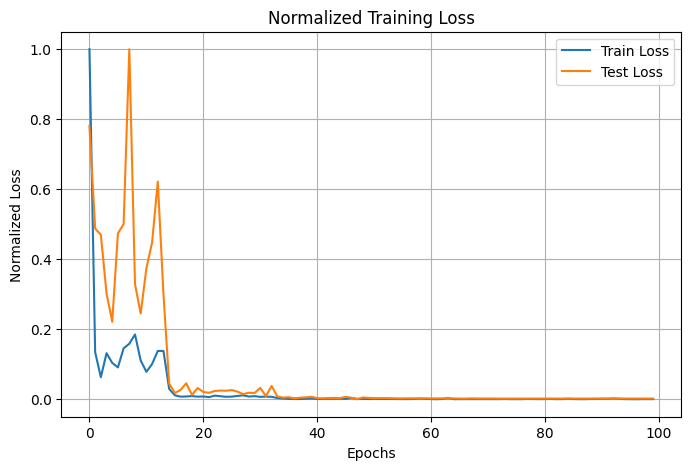

In [31]:
# Instantiate the model
model_0 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Epoch 0 | Loss train: 605.5058195040776 | Loss test: 165.30237361363 | lr = 0.01
Epoch 10 | Loss train: 30.256738149202786 | Loss test: 48.90731430053711 | lr = 0.01
Epoch 20 | Loss train: 27.74244836660532 | Loss test: 28.969479969569615 | lr = 0.01
Epoch 30 | Loss train: 28.389570603003868 | Loss test: 51.82192393711635 | lr = 0.01
Epoch 40 | Loss train: 25.327790700472317 | Loss test: 36.19647107805525 | lr = 0.01
Epoch 50 | Loss train: 30.965181460747353 | Loss test: 57.46832166399275 | lr = 0.01
Epoch 60 | Loss train: 0.8294364397342389 | Loss test: 1.143014635358538 | lr = 0.001
Epoch 70 | Loss train: 0.8700397897225159 | Loss test: 1.0508886745997839 | lr = 0.001
Epoch 80 | Loss train: 0.8394781603262975 | Loss test: 1.0851765530450004 | lr = 0.001
Epoch 90 | Loss train: 0.5000296108997785 | Loss test: 0.69552310023989 | lr = 0.0001
Epoch 100 | Loss train: 0.49370140639635235 | Loss test: 0.657210213797433 | lr = 0.0001


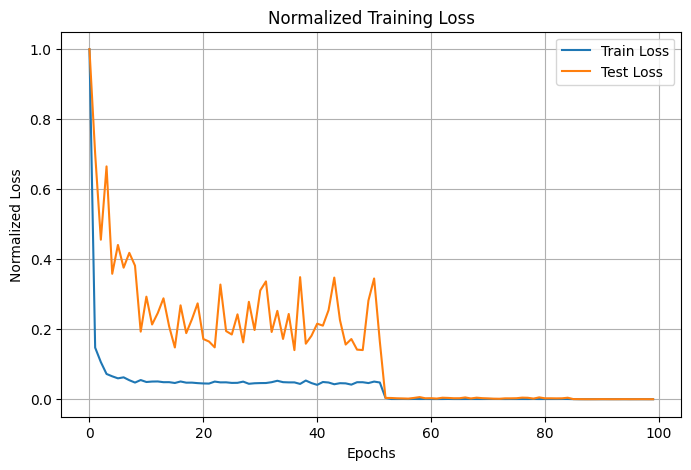

In [32]:
# Instantiate the model
model_1 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_1.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_1, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Epoch 0 | Loss train: 0.9935246585653379 | Loss test: 0.9201039246150425 | lr = 0.01
Epoch 10 | Loss train: 0.7595437318086624 | Loss test: 0.9440432020596096 | lr = 0.01
Epoch 20 | Loss train: 0.5056882878908744 | Loss test: 0.6513453807149615 | lr = 0.001
Epoch 30 | Loss train: 0.5075902721056571 | Loss test: 0.655952411038535 | lr = 0.0001
Epoch 40 | Loss train: 0.46860029376470125 | Loss test: 0.6199503455843244 | lr = 0.0001
Epoch 50 | Loss train: 0.48330617065613085 | Loss test: 0.6179724676268441 | lr = 0.0001
Epoch 60 | Loss train: 0.4762005668420058 | Loss test: 0.6191169364111764 | lr = 1e-05
Epoch 70 | Loss train: 0.47306132545837987 | Loss test: 0.6188441174370902 | lr = 1e-05
Epoch 80 | Loss train: 0.47552182926581454 | Loss test: 0.6185925560338157 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.4856286071814023 | Loss test: 0.6185578618730817 | lr = 1.0000000000000002e-07
Epoch 100 | Loss train: 0.4736424214564837 | Loss test: 0.6185556607586997 | lr = 1.000000000

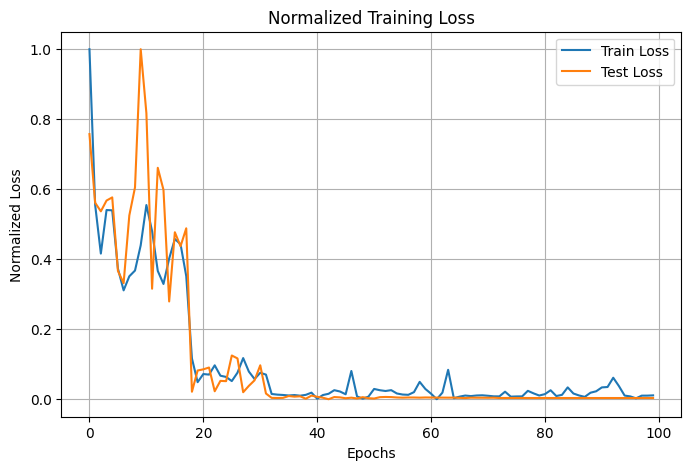

In [33]:
# Instantiate the model
model_2 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate, momentum= 0.9)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_2, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [34]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 9.113105566455769 | Loss test: 0.9366510936192104 | lr = 0.01
Epoch 10 | Loss train: 0.765847269159097 | Loss test: 0.8018285036087036 | lr = 0.01
Epoch 20 | Loss train: 0.6560965455495394 | Loss test: 0.869704612663814 | lr = 0.01
Epoch 30 | Loss train: 0.6101173552183005 | Loss test: 0.7344011494091579 | lr = 0.001
Epoch 40 | Loss train: 0.5773171707987785 | Loss test: 0.7264106018202645 | lr = 0.001
Epoch 50 | Loss train: 0.49795535321419054 | Loss test: 0.6614141123635429 | lr = 0.001
Epoch 60 | Loss train: 0.43540787123716795 | Loss test: 0.6155989340373448 | lr = 0.001
Epoch 70 | Loss train: 0.3977720554058368 | Loss test: 0.6498639753886631 | lr = 0.001
Epoch 80 | Loss train: 0.3871450229332997 | Loss test: 0.6105321219989231 | lr = 0.001
Epoch 90 | Loss train: 0.3752083715337973 | Loss test: 0.5816686919757298 | lr = 0.001
Epoch 100 | Loss train: 0.326555497944355 | Loss test: 0.6158439261572701 | lr = 0.001


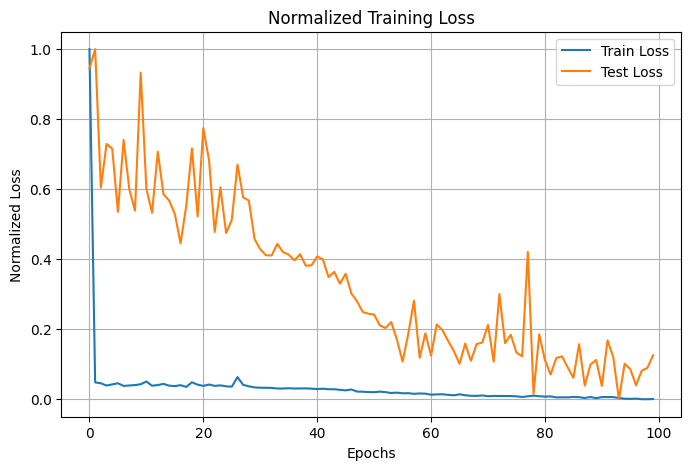

In [35]:
# Instantiate the model
model_3 = ReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_3, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model = eval_model(model_3, test_loader, scaler_rev, device)

In [36]:
relu_model

{'model_name': 'ReLUModel',
 'mean_distance_error_cm': 15.650593757629395,
 'std': 11.23022174835205}

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική. **NOT**

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

Epoch 0 | Loss train: 21.193686123077686 | Loss test: 1.040188729763031 | lr = 0.01
Epoch 10 | Loss train: 0.7634298881659141 | Loss test: 0.8729806286948067 | lr = 0.01
Epoch 20 | Loss train: 0.7730783739915261 | Loss test: 0.8941055280821664 | lr = 0.01
Epoch 30 | Loss train: 0.6300891431478354 | Loss test: 0.7468375478472028 | lr = 0.001
Epoch 40 | Loss train: 0.5891520145993966 | Loss test: 0.7387769051960537 | lr = 0.001
Epoch 50 | Loss train: 0.5904404945098437 | Loss test: 0.7417571118899754 | lr = 0.001
Epoch 60 | Loss train: 0.5882045271304938 | Loss test: 0.7232304215431213 | lr = 0.001
Epoch 70 | Loss train: 0.5788723849333249 | Loss test: 0.7224947128977094 | lr = 0.001
Epoch 80 | Loss train: 0.5745464632144341 | Loss test: 0.7127592393330165 | lr = 0.0001
Epoch 90 | Loss train: 0.5713779937762481 | Loss test: 0.7057290077209473 | lr = 0.0001
Epoch 100 | Loss train: 0.5540844752238347 | Loss test: 0.7042717167309352 | lr = 0.0001


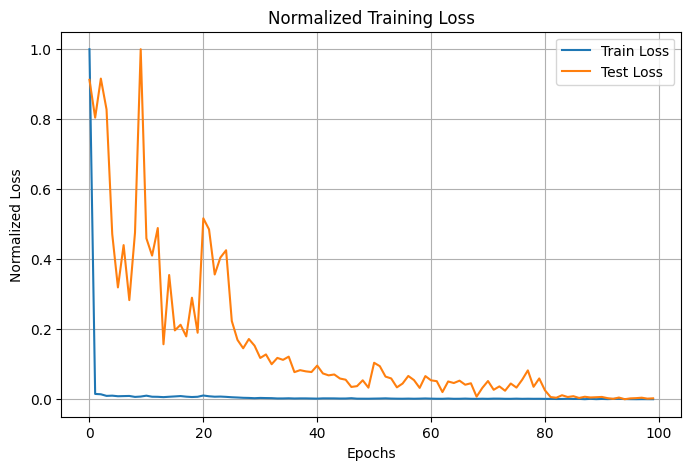

In [37]:
# Instantiate the model
model_4 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 256)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 100,model = model_4, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_256 = eval_model(model_4, test_loader, scaler_rev, device)

In [38]:
relu_model_256, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 16.499380111694336,
  'std': 10.743680953979492},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 15.650593757629395,
  'std': 11.23022174835205})

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64. **NOT**

Epoch 0 | Loss train: 3.359044467027371 | Loss test: 0.9904140744890485 | lr = 0.01
Epoch 10 | Loss train: 0.6348620469753559 | Loss test: 0.7458373308181763 | lr = 0.01
Epoch 20 | Loss train: 0.49722993946992433 | Loss test: 0.6532959384577615 | lr = 0.01
Epoch 30 | Loss train: 0.4211210860655858 | Loss test: 0.5924452670982906 | lr = 0.01
Epoch 40 | Loss train: 0.42700818754159486 | Loss test: 0.5108706142221179 | lr = 0.01
Epoch 50 | Loss train: 0.434610852255271 | Loss test: 0.6230303645133972 | lr = 0.01
Epoch 60 | Loss train: 0.44165907685573286 | Loss test: 0.5409275037901742 | lr = 0.01
Epoch 70 | Loss train: 0.4758791889135654 | Loss test: 0.5745193106787545 | lr = 0.01
Epoch 80 | Loss train: 0.4227354211302904 | Loss test: 0.6115339696407318 | lr = 0.01
Epoch 90 | Loss train: 0.2957160226427592 | Loss test: 0.5048055989401681 | lr = 0.001
Epoch 100 | Loss train: 0.2657349482178688 | Loss test: 0.4658343323639461 | lr = 0.001
Epoch 110 | Loss train: 0.26242600782559466 | Loss 

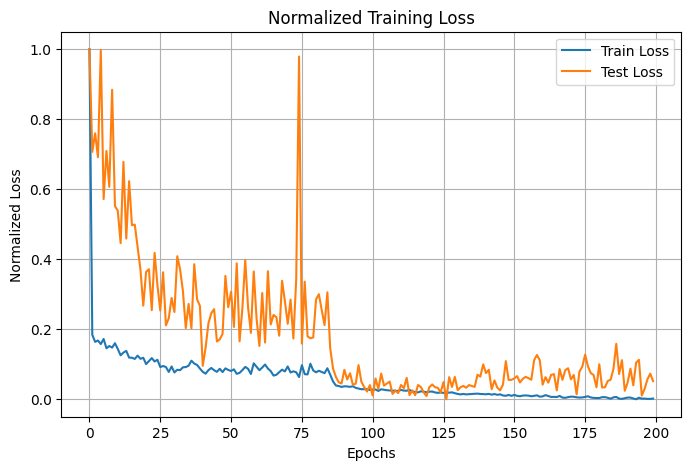

In [39]:
# Instantiate the model
model_5 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 64)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

arr1, arr2 = train_test_model(epoch = 200,model = model_5, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

relu_model_64 = eval_model(model_5, test_loader, scaler_rev, device)

In [40]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 16.499380111694336,
  'std': 10.743680953979492},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 13.864714622497559,
  'std': 10.064838409423828},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 15.650593757629395,
  'std': 11.23022174835205})

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [41]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 3.2734085619449615 | Loss test: 1.1317337921687536 | lr = 0.01
Epoch 10 | Loss train: 0.592142776801036 | Loss test: 0.848790534905025 | lr = 0.01
Epoch 20 | Loss train: 0.4736921042203903 | Loss test: 0.6233449535710471 | lr = 0.01
Epoch 30 | Loss train: 0.5510049554017874 | Loss test: 0.6772208341530391 | lr = 0.01
Epoch 40 | Loss train: 0.26816000474187046 | Loss test: 0.4536215045622417 | lr = 0.001
Epoch 50 | Loss train: 0.22093956974836496 | Loss test: 0.4225324605192457 | lr = 0.001
Epoch 60 | Loss train: 0.17098645865917206 | Loss test: 0.43385117820331026 | lr = 0.001
Epoch 70 | Loss train: 0.15003463110098472 | Loss test: 0.4488800849233355 | lr = 0.001
Epoch 80 | Loss train: 0.1354402627509374 | Loss test: 0.4270322450569698 | lr = 0.001
Epoch 90 | Loss train: 0.11387975184390178 | Loss test: 0.4158466373171125 | lr = 0.001
Epoch 100 | Loss train: 0.08988971134217885 | Loss test: 0.43200795139585224 | lr = 0.001
Epoch 110 | Loss train: 0.093278345580284

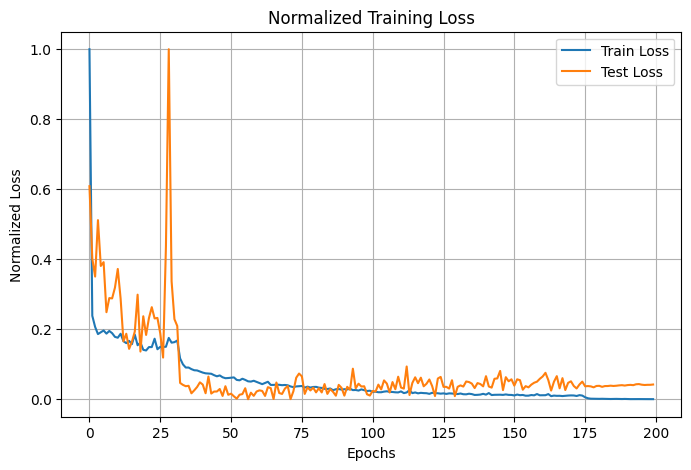

In [42]:
# Instantiate the model
model_6 = LeakyReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_6, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu = eval_model(model_6, test_loader, scaler_rev, device)

In [43]:
leakyrelu

{'model_name': 'LeakyReLUModel',
 'mean_distance_error_cm': 11.34581470489502,
 'std': 10.055803298950195}

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [44]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.8857216720397656 | Loss test: 0.8815774747303554 | lr = 0.01
Epoch 10 | Loss train: 0.5797926577237936 | Loss test: 0.8861062271254403 | lr = 0.01
Epoch 20 | Loss train: 0.5379975587129593 | Loss test: 0.794957480260304 | lr = 0.01
Epoch 30 | Loss train: 0.5120335863186762 | Loss test: 0.7951299122401646 | lr = 0.01
Epoch 40 | Loss train: 0.3803488445969728 | Loss test: 0.8299522612776075 | lr = 0.001
Epoch 50 | Loss train: 0.3077489407016681 | Loss test: 0.8386728337832859 | lr = 0.001
Epoch 60 | Loss train: 0.25583247267282927 | Loss test: 0.8378446783338275 | lr = 0.001
Epoch 70 | Loss train: 0.21487835450814322 | Loss test: 0.8504373005458287 | lr = 0.001
Epoch 80 | Loss train: 0.1917526704760698 | Loss test: 0.8491357948098864 | lr = 0.001
Epoch 90 | Loss train: 0.18052159106502166 | Loss test: 0.8448191114834377 | lr = 0.001
Epoch 100 | Loss train: 0.14923549787356302 | Loss test: 0.8548605442047119 | lr = 0.001
Epoch 110 | Loss train: 0.13635277576171434 

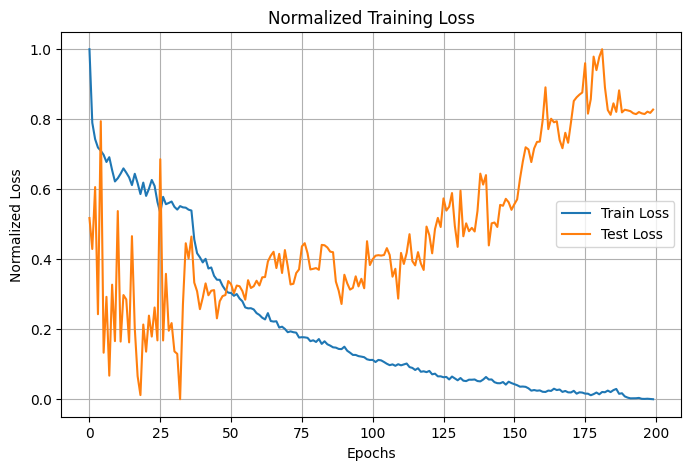

In [45]:
# Instantiate the model
model_8 = tanhModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_8.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_8, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

tanh_model = eval_model(model_8, test_loader, scaler_rev, device)

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [46]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.8184342074852723 | Loss test: 0.9220450265066964 | lr = 0.01
Epoch 10 | Loss train: 0.5444477911178882 | Loss test: 0.719656126839774 | lr = 0.01
Epoch 20 | Loss train: 0.5130588847857255 | Loss test: 0.7311328223773411 | lr = 0.01
Epoch 30 | Loss train: 0.4728827808911984 | Loss test: 0.7782960108348301 | lr = 0.01
Epoch 40 | Loss train: 0.43188532900351745 | Loss test: 0.6912132927349636 | lr = 0.01
Epoch 50 | Loss train: 0.39888140100699204 | Loss test: 0.6885281801223755 | lr = 0.01
Epoch 60 | Loss train: 0.3738461956381798 | Loss test: 0.6914661824703217 | lr = 0.01
Epoch 70 | Loss train: 0.35419011001403516 | Loss test: 0.6629459006445748 | lr = 0.01
Epoch 80 | Loss train: 0.31576458422037273 | Loss test: 0.6264582659517016 | lr = 0.01
Epoch 90 | Loss train: 0.31902704445215374 | Loss test: 0.7391420177050999 | lr = 0.01
Epoch 100 | Loss train: 0.26222912537363857 | Loss test: 0.7817255684307644 | lr = 0.001
Epoch 110 | Loss train: 0.2391817678625767 | Los

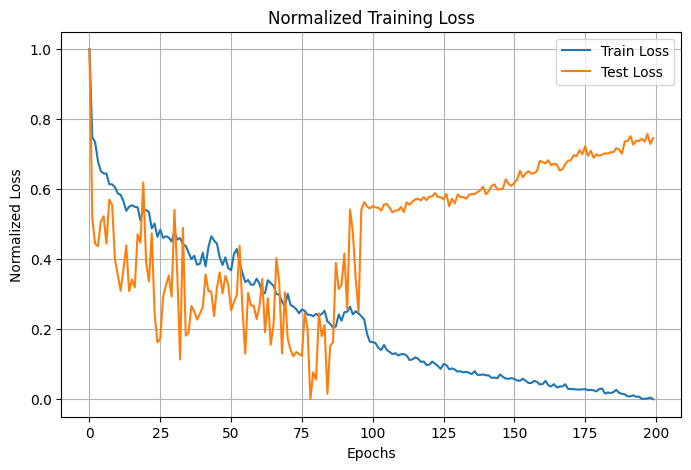

In [47]:
# Instantiate the model
model_9 = sigmoidModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_9.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_9, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

sigmoid_model = eval_model(model_9, test_loader, scaler_rev, device)

### Αρχιτεκτονική 3

#### +1 Layer

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [48]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.4793574936114824 | Loss test: 0.9588226846286229 | lr = 0.01
Epoch 10 | Loss train: 0.5423058271408081 | Loss test: 0.7040493530886514 | lr = 0.01
Epoch 20 | Loss train: 0.4688402357009741 | Loss test: 0.6539105687822614 | lr = 0.01
Epoch 30 | Loss train: 0.4593597593215796 | Loss test: 0.6622655136244637 | lr = 0.01
Epoch 40 | Loss train: 0.35447834260188615 | Loss test: 0.5421682894229889 | lr = 0.01
Epoch 50 | Loss train: 0.34691490634129596 | Loss test: 0.5761596390179226 | lr = 0.01
Epoch 60 | Loss train: 0.3614702568604396 | Loss test: 0.5042465584618705 | lr = 0.01
Epoch 70 | Loss train: 0.21184394193383363 | Loss test: 0.44314790623528616 | lr = 0.001
Epoch 80 | Loss train: 0.1463378521685417 | Loss test: 0.45660364840711865 | lr = 0.001
Epoch 90 | Loss train: 0.11123948357999325 | Loss test: 0.447461126106126 | lr = 0.001
Epoch 100 | Loss train: 0.08612942709945716 | Loss test: 0.4416267382247107 | lr = 0.001
Epoch 110 | Loss train: 0.06709987863611716 

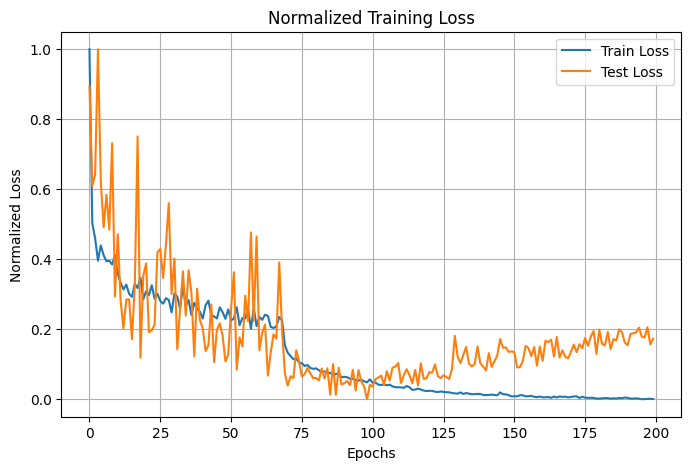

In [49]:
# Instantiate the model
model_10 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_10, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_4 = eval_model(model_10, test_loader, scaler_rev, device)

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

#### -1 Layer

In [50]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 41.55031408713414 | Loss test: 3.6619315147399902 | lr = 0.01
Epoch 10 | Loss train: 0.7091942028357432 | Loss test: 0.7405496920858111 | lr = 0.01
Epoch 20 | Loss train: 0.7251400821484052 | Loss test: 0.8797979865755353 | lr = 0.01
Epoch 30 | Loss train: 0.6888974606990814 | Loss test: 0.7121998923165458 | lr = 0.001
Epoch 40 | Loss train: 0.36087857100826043 | Loss test: 0.5104843378067017 | lr = 0.001
Epoch 50 | Loss train: 0.34006727314912355 | Loss test: 0.5379680267402104 | lr = 0.001
Epoch 60 | Loss train: 0.3081235272380022 | Loss test: 0.5010455165590558 | lr = 0.001
Epoch 70 | Loss train: 0.2954467752805123 | Loss test: 0.49786244545664105 | lr = 0.001
Epoch 80 | Loss train: 0.3033148583311301 | Loss test: 0.49480366706848145 | lr = 0.001
Epoch 90 | Loss train: 0.29472432686732364 | Loss test: 0.47766898359571186 | lr = 0.001
Epoch 100 | Loss train: 0.27505168318748474 | Loss test: 0.5343282052448818 | lr = 0.001
Epoch 110 | Loss train: 0.24926360066120

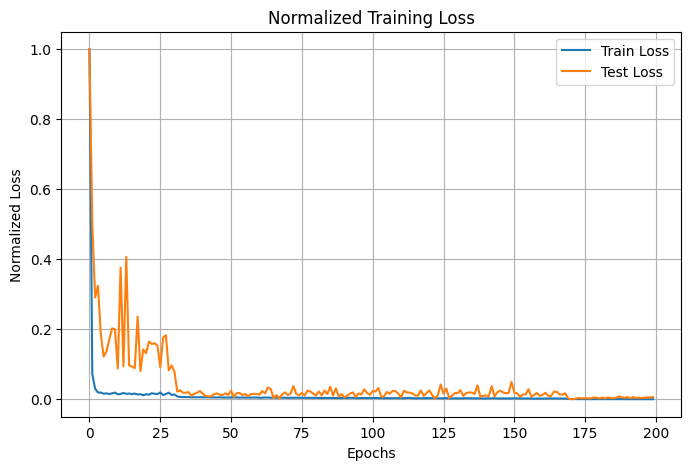

In [51]:
# Instantiate the model
model_14 = LeakyReLUModel2(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_14.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_14, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_2 = eval_model(model_14, test_loader, scaler_rev, device)

#### -1 Layer rmsprop

In [52]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 2524.1646390786536 | Loss test: 467.33531406947543 | lr = 0.01
Epoch 10 | Loss train: 4.048609447020751 | Loss test: 1.9062854732785905 | lr = 0.01
Epoch 20 | Loss train: 3.446339847949835 | Loss test: 1.788234259401049 | lr = 0.01
Epoch 30 | Loss train: 0.4693233806353349 | Loss test: 0.592728682926723 | lr = 0.001
Epoch 40 | Loss train: 0.38130963765657866 | Loss test: 0.5724834203720093 | lr = 0.001
Epoch 50 | Loss train: 0.3846522277364364 | Loss test: 0.49520805052348543 | lr = 0.001
Epoch 60 | Loss train: 0.35008732630656314 | Loss test: 0.5597564620631081 | lr = 0.001
Epoch 70 | Loss train: 0.33840741446385014 | Loss test: 0.5060173869132996 | lr = 0.001
Epoch 80 | Loss train: 0.31978551413004214 | Loss test: 0.5169173989977155 | lr = 0.001
Epoch 90 | Loss train: 0.3232101643314728 | Loss test: 0.463944992848805 | lr = 0.001
Epoch 100 | Loss train: 0.3174506460244839 | Loss test: 0.4513892446245466 | lr = 0.001
Epoch 110 | Loss train: 0.28928370487231475 | 

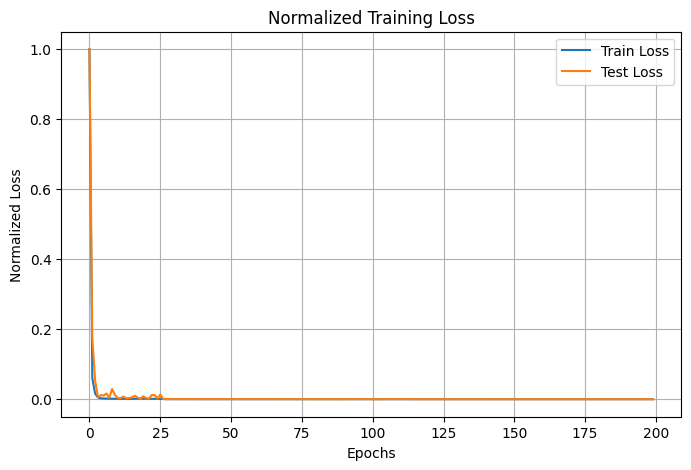

In [53]:
# Instantiate the model
model_15 = LeakyReLUModel2(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_15.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_15, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

leakyrelu_2_rms = eval_model(model_15, test_loader, scaler_rev, device)

### Αρχιτεκτονική 4

#### Dropout

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [54]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 3.939955616226563 | Loss test: 0.9727592723710197 | lr = 0.01
Epoch 10 | Loss train: 0.7167485780440844 | Loss test: 0.707415691443852 | lr = 0.01
Epoch 20 | Loss train: 0.6595354206286944 | Loss test: 0.7675735652446747 | lr = 0.01
Epoch 30 | Loss train: 0.44235526139919573 | Loss test: 0.48507021154676166 | lr = 0.001
Epoch 40 | Loss train: 0.36565845574323946 | Loss test: 0.44898147668157307 | lr = 0.001
Epoch 50 | Loss train: 0.355214183147137 | Loss test: 0.43479118602616446 | lr = 0.001
Epoch 60 | Loss train: 0.3121537835552142 | Loss test: 0.43140099729810444 | lr = 0.001
Epoch 70 | Loss train: 0.32087018340826035 | Loss test: 0.4314036411898477 | lr = 0.001
Epoch 80 | Loss train: 0.26541401732426423 | Loss test: 0.3994530013629368 | lr = 0.0001
Epoch 90 | Loss train: 0.26265640556812286 | Loss test: 0.4038410910538265 | lr = 0.0001
Epoch 100 | Loss train: 0.26713169652682084 | Loss test: 0.40182871903691975 | lr = 0.0001
Epoch 110 | Loss train: 0.245341462

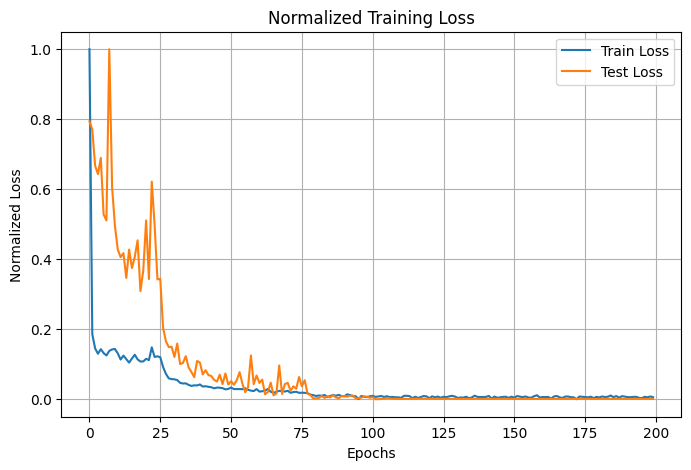

In [55]:
# Instantiate the model
model_11 = LeakyReLUModelDropout(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_11.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_11, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(arr1, arr2)

dropout_model = eval_model(model_11, test_loader, scaler_rev, device)

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [56]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)


In [58]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred)
y_true_real = scaler_Y.inverse_transform(y_test)

xgb_loss = np.mean(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_var = np.std(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_res = {'model_name': 'xgb_model', 'mean_distance_error_cm' : xgb_loss, 'std': xgb_var}

c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [59]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [60]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)


In [61]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


model_13.eval()
with torch.inference_mode():
    y_pred = model_13(X_test_tensor)
# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred.cpu())
y_true_real = scaler_Y.inverse_transform(y_test_tensor.cpu())

distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
mean_distance_error = np.mean(distances)
std = np.std(distances)

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'mean_distance_error_cm' : mean_distance_error.item(), 'std': std.item()}

Epoch: 0 | Train Loss: 1.00991 | Test Loss: 2.09000
Epoch: 100 | Train Loss: 0.15306 | Test Loss: 0.52843
Epoch: 200 | Train Loss: 0.15286 | Test Loss: 0.52793
Epoch: 300 | Train Loss: 0.15286 | Test Loss: 0.52793
Epoch: 400 | Train Loss: 0.15286 | Test Loss: 0.52793
Epoch: 500 | Train Loss: 0.15285 | Test Loss: 0.52793
Epoch: 600 | Train Loss: 0.15285 | Test Loss: 0.52793
Epoch: 700 | Train Loss: 0.15285 | Test Loss: 0.52792
Epoch: 800 | Train Loss: 0.15285 | Test Loss: 0.52792
Epoch: 900 | Train Loss: 0.15284 | Test Loss: 0.52791
Epoch: 1000 | Train Loss: 0.15284 | Test Loss: 0.52791


## Results

In [62]:
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, sigmoid_model, tanh_model])
compare_results = compare_results._append(xgb_res, ignore_index = True)
compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'mean_distance_error_cm', ascending= True, inplace= True)

compare_results

,model_name,mean_distance_error_cm,std
0,LeakyReLUModel,11.345815,10.055803
5,LeakyReLUModelDropout,11.745638,9.233783
3,LeakyReLUModel2,12.032551,8.854071
2,LeakyReLUModel2,12.219290,9.798367
1,LeakyReLUModel4,12.529461,12.104103
9,LeakyReLU4_noBatches,12.722304,10.168433
8,xgb_model,14.153856,10.724038
4,ReLUModel,15.650594,11.230222
6,sigmoidModel,16.992296,12.903430
7,tanhModel,20.535139,13.044345


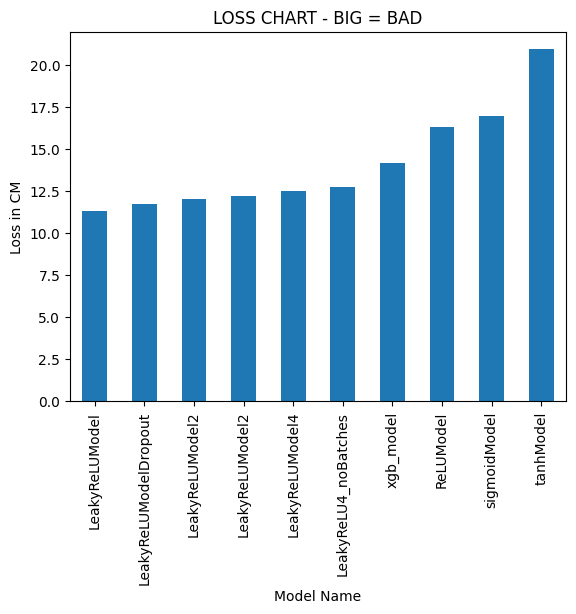

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["mean_distance_error_cm"].plot(kind="bar")
plt.xlabel("Model Name")
plt.ylabel("Loss in CM")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***